# Coffee Data Notebook

Looking at different aspects of the data, mostly to improve collection and have more awareness.


In [1]:
import os
import math

from collections import defaultdict
from tempfile import NamedTemporaryFile

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from optpresso import __file__ as optpresso_path
from optpresso.data.partition import find_test_paths

from IPython.core.display import display

In [2]:
# Modifiy this to point at the directory where all of the images live.
DATA_DIR = os.path.expanduser("~/coffee-images/")
OPTPRESSO_DIR = os.path.dirname(optpresso_path)
DATA_DOWNLOAD_URL = "https://docs.google.com/spreadsheets/d/1dDfuIq74pjELNtfb_0sdiNnG3qFKrfqC2sax7ewrWYg/export?format=csv"
plt.rcParams["figure.dpi"] = 150

images_by_time = defaultdict(list)
for time, img_path in find_test_paths(DATA_DIR):
    images_by_time[time].append(img_path)

### Data Distribution

The following graph presents the number of images associated with each pull time. Useful to determine where more data needs to be collected.

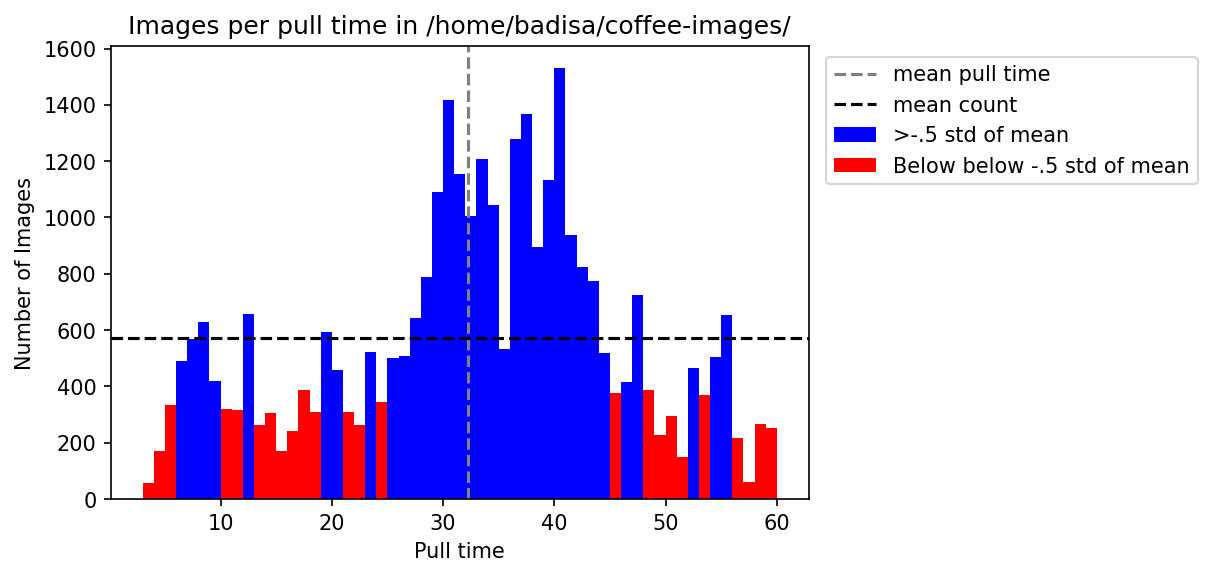

24 pull times which could do with more data
48
49
3
16
53
51
4
24
17
60
56
10
21
5
45
57
15
50
11
22
18
14
13
58


In [3]:
counts = []
for key, val in images_by_time.items():
    counts.append((key, len(val)))
mean_count = np.mean([x[1] for x in counts])
std_count = np.std([x[1] for x in counts])
# counts.sort(key=lambda x: x[1])
lowest = [x[0] for x in counts if x[1] < mean_count - std_count * .5]
good_hist_data = []
low_hist_data = []
for key, val in images_by_time.items():
    if key in lowest:
        for _ in range(len(val)):
            low_hist_data.append(key)
    else:
        for _ in range(len(val)):
            good_hist_data.append(key)
#     print(f"{time}s {count} images")
plt.hist(
    [good_hist_data, low_hist_data],
    len(images_by_time),
    color=["blue", "red"],
    stacked=True,
    label=[">-.5 std of mean", "Below below -.5 std of mean"]
)
plt.xlabel("Pull time")
plt.ylabel("Number of Images")
plt.title(f"Images per pull time in {DATA_DIR}")
plt.axvline(np.mean(good_hist_data + low_hist_data), label="mean pull time", linestyle="--", color="gray")
plt.axhline(mean_count, label="mean count", linestyle="--", color="black")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()
print(len(lowest), "pull times which could do with more data")
for low in lowest:
    print(low)

### Grinder/Pull Variation

The following looks at the variation seen in shot pull times at the same grind setting. Assumes a normal distribution of the shot times, which has yet to be confirmed.

Only evaluate in cases where there are between 5 and 20 shots. Until there is a decent way to partition the shots by time/batch, it seems unreasonable to evaluate larger batches.

In [4]:
# Download CSV, won't work on windozes
with NamedTemporaryFile(suffix=".csv") as temp:
    with open(temp.name, "wb") as ofs:
        resp = requests.get(DATA_DOWNLOAD_URL, stream=True)
        for chunk in resp.iter_content():
            ofs.write(chunk)
    df = pd.read_csv(temp.name)
# Clean up the CSV file.
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '').str.replace('(', '').str.replace(')', '')
df = df[df["grinder"].astype(bool)][df["grindersetting"].astype(bool)]
# Only care about data that has a grinder associated
invalid_indices = df[(df["grinder"] == "None") & (df["details"] == "prediction")].index
df.drop(invalid_indices, inplace=True)

Fit func  
0.09844 x - 0.5413


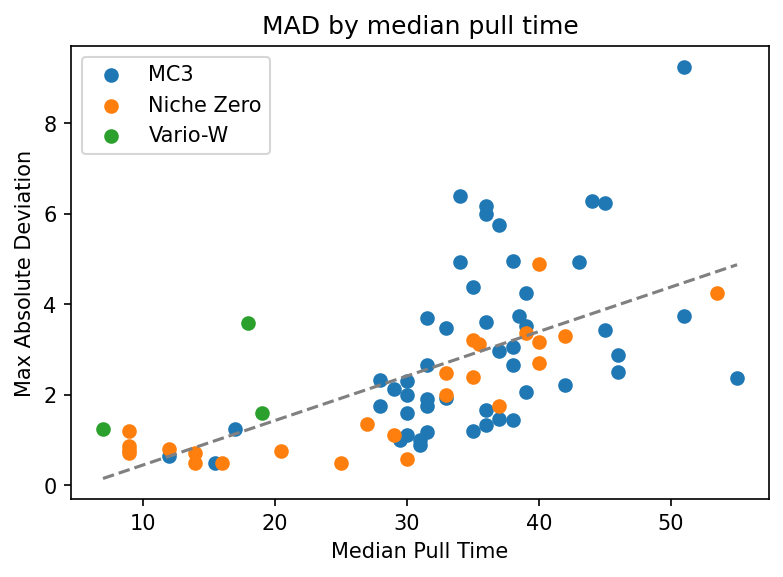

Fit func  
0.1018 x - 0.6616


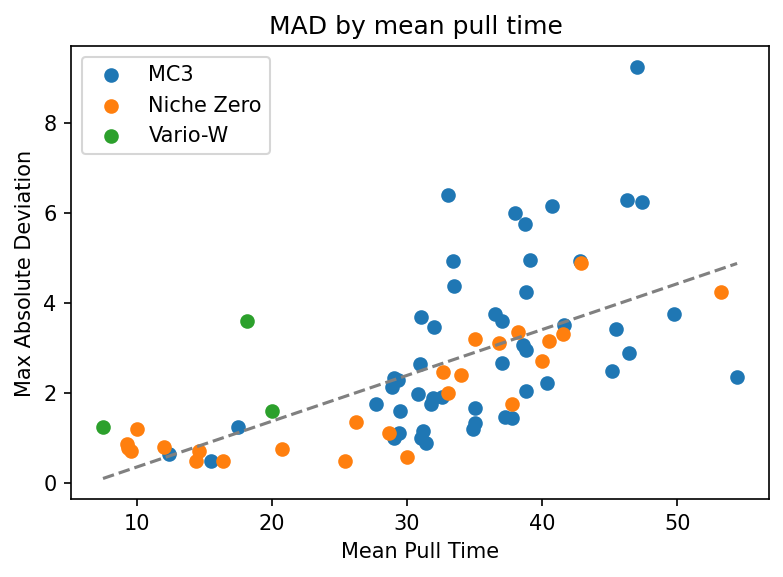

In [5]:
groupby = ["grinder", "grindersetting", "coffee"]
# Strip out more than 20 shots (more than a single 12oz bag) and less than 3
grouped = df.groupby(groupby).filter(lambda x: 20 >= len(x) > 3).groupby(groupby)
df_med = grouped.median()
df_mad = grouped.mad()
x = defaultdict(list)
y = defaultdict(list)
for indice in df_mad.index:
    if indice not in df_med.index:
        continue
    if math.isnan(df_med.time[indice]) or math.isnan(df_mad.time[indice]):
        continue
    grinder = indice[0]
    x[grinder].append(df_med.time[indice])
    y[grinder].append(df_mad.time[indice])
all_x = []
all_y = []
for grinder in x.keys():
    all_x.extend(x[grinder])
    all_y.extend(y[grinder])
    plt.scatter(x[grinder], y[grinder], label=grinder)
poly_fit = np.poly1d(np.polyfit(all_x, all_y, 1))
print("Fit func", poly_fit)
plt.plot(
    np.unique(all_x),
    poly_fit(np.unique(all_x)),
    color="gray",
    linestyle="--",
)
plt.xlabel("Median Pull Time")
plt.ylabel("Max Absolute Deviation")
plt.title("MAD by median pull time")
plt.legend()
plt.show()

df_mean = grouped.mean()
x = defaultdict(list)
y = defaultdict(list)
for indice in df_mean.index:
    if indice not in df_mad.index:
        continue
    grinder = indice[0]
    if math.isnan(df_mean.time[indice]) or math.isnan(df_mad.time[indice]):
        continue
    x[grinder].append(df_mean.time[indice])
    y[grinder].append(df_mad.time[indice])
all_x = []
all_y = []
for grinder in x.keys():
    all_x.extend(x[grinder])
    all_y.extend(y[grinder])
    plt.scatter(x[grinder], y[grinder], label=grinder)
poly_fit = np.poly1d(np.polyfit(all_x, all_y, 1))
print("Fit func", poly_fit)
plt.plot(
    np.unique(all_x),
    poly_fit(np.unique(all_x)),
    color="gray",
    linestyle="--",
)
plt.xlabel("Mean Pull Time")
plt.ylabel("Max Absolute Deviation")
plt.title("MAD by mean pull time ")
plt.legend()
plt.show()

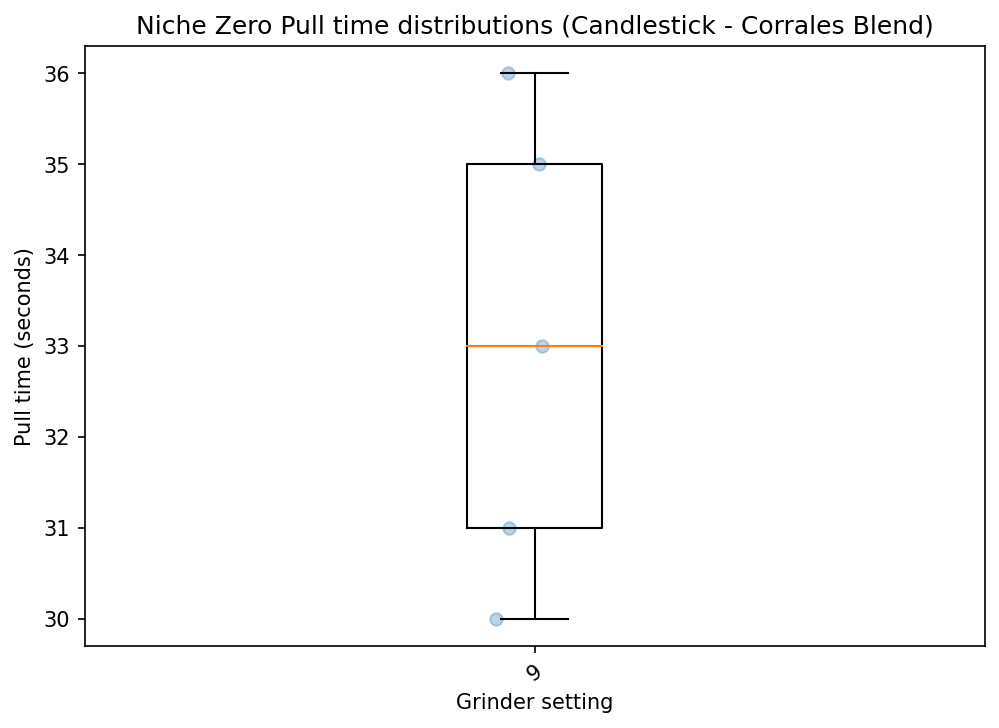

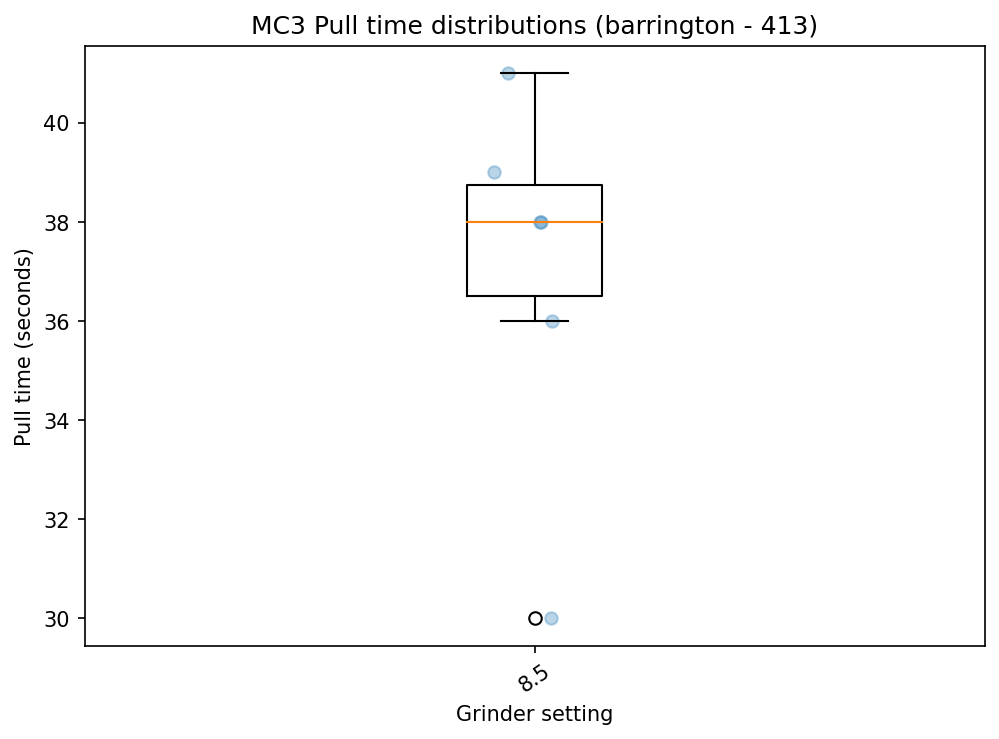

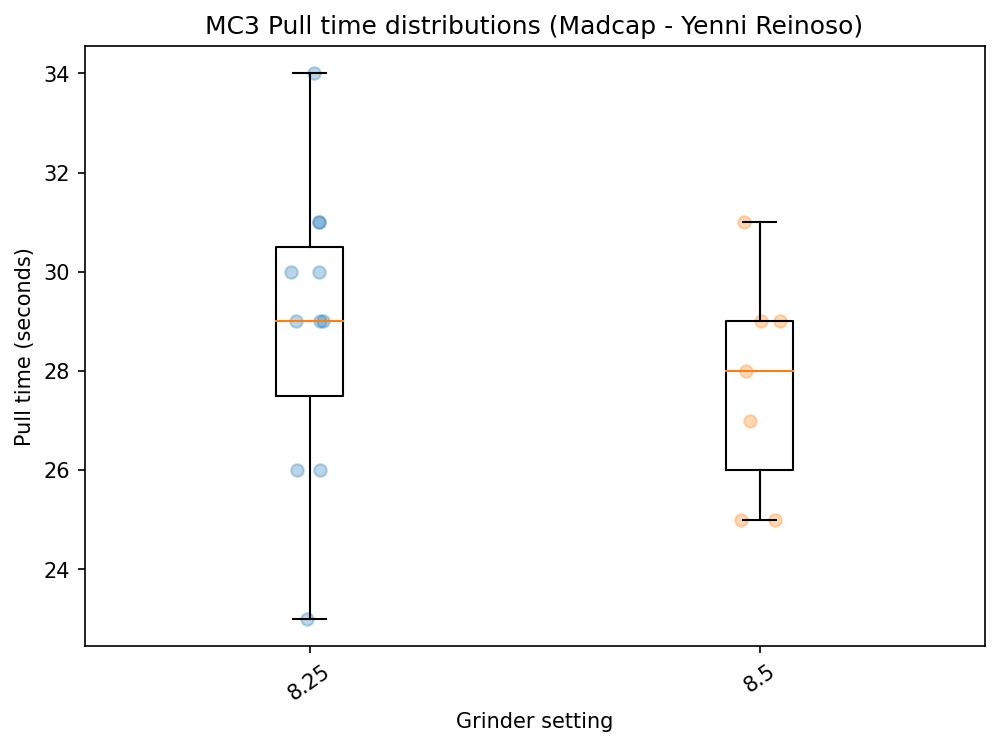

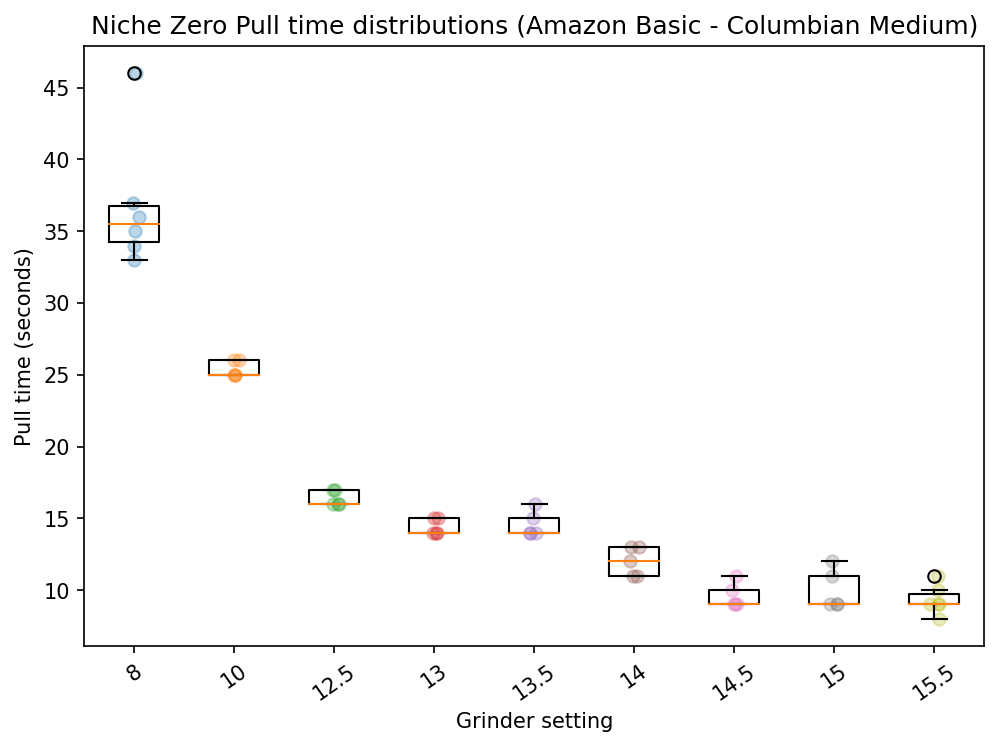

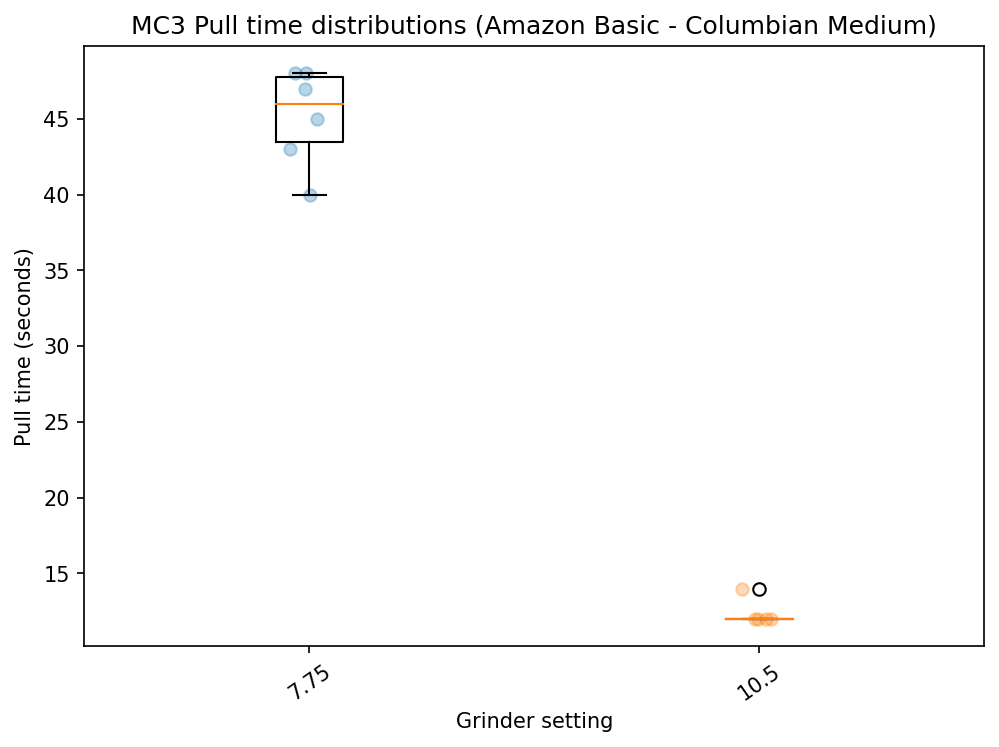

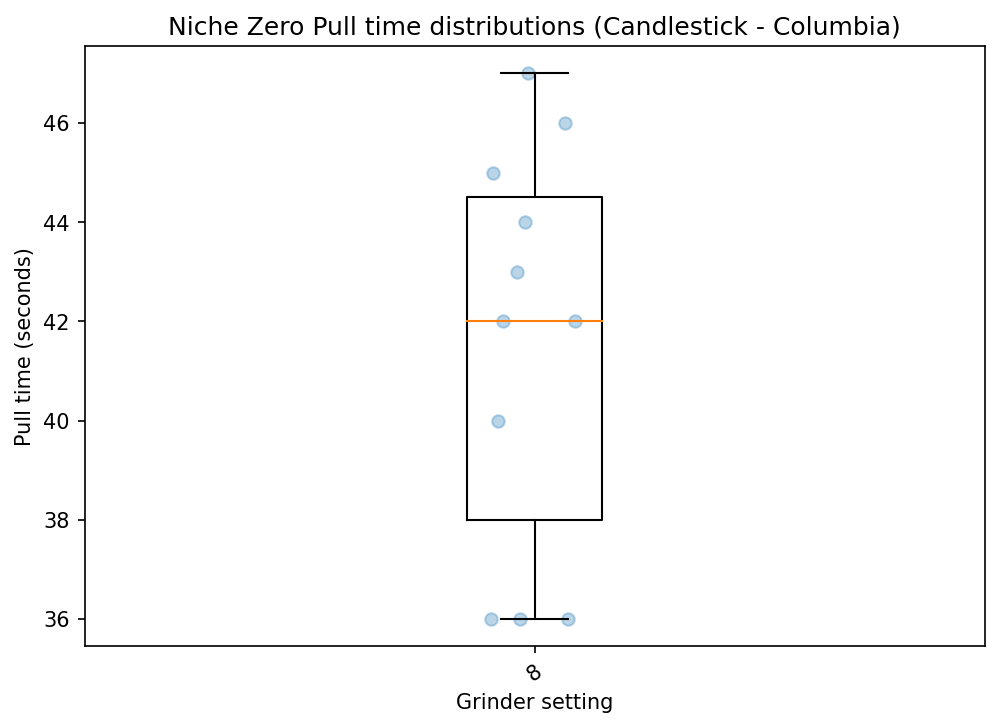

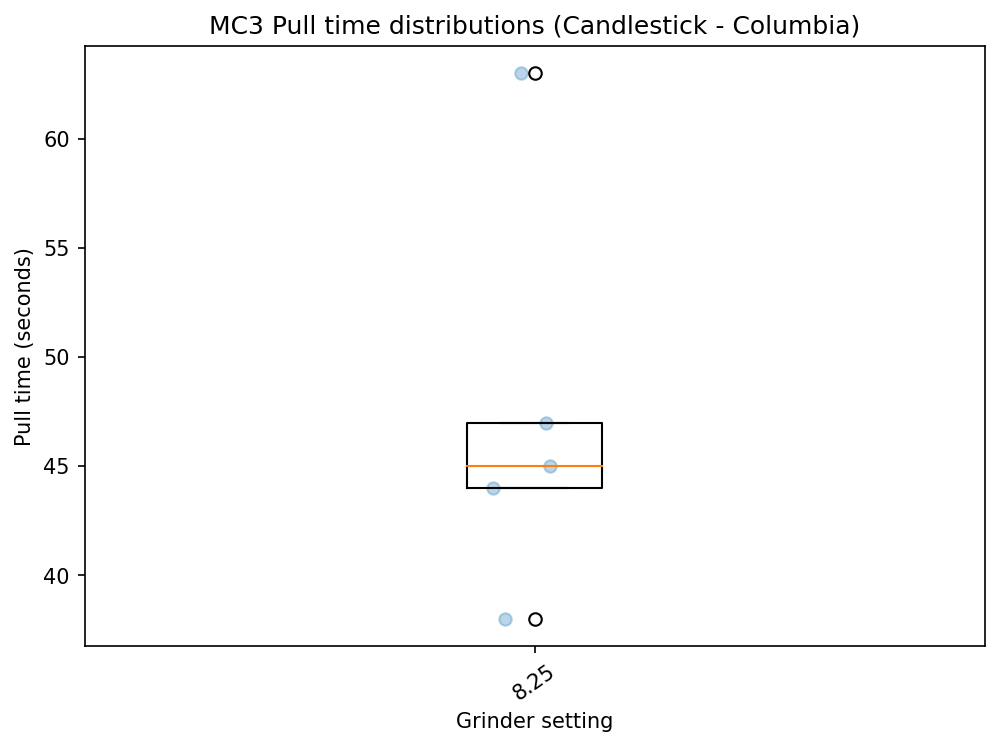

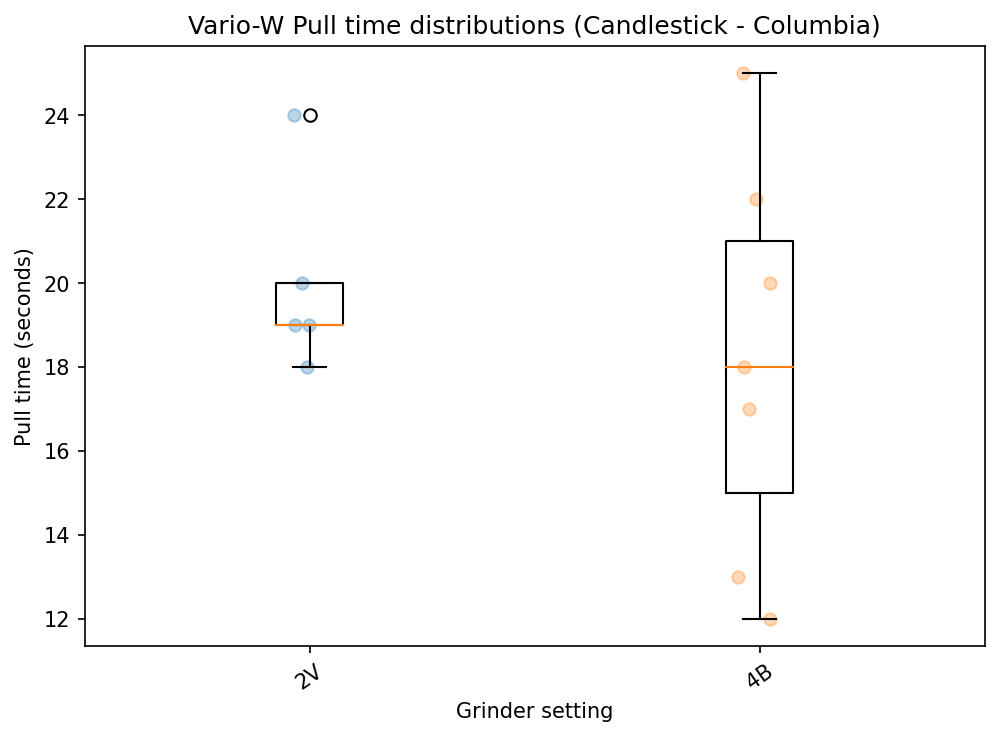

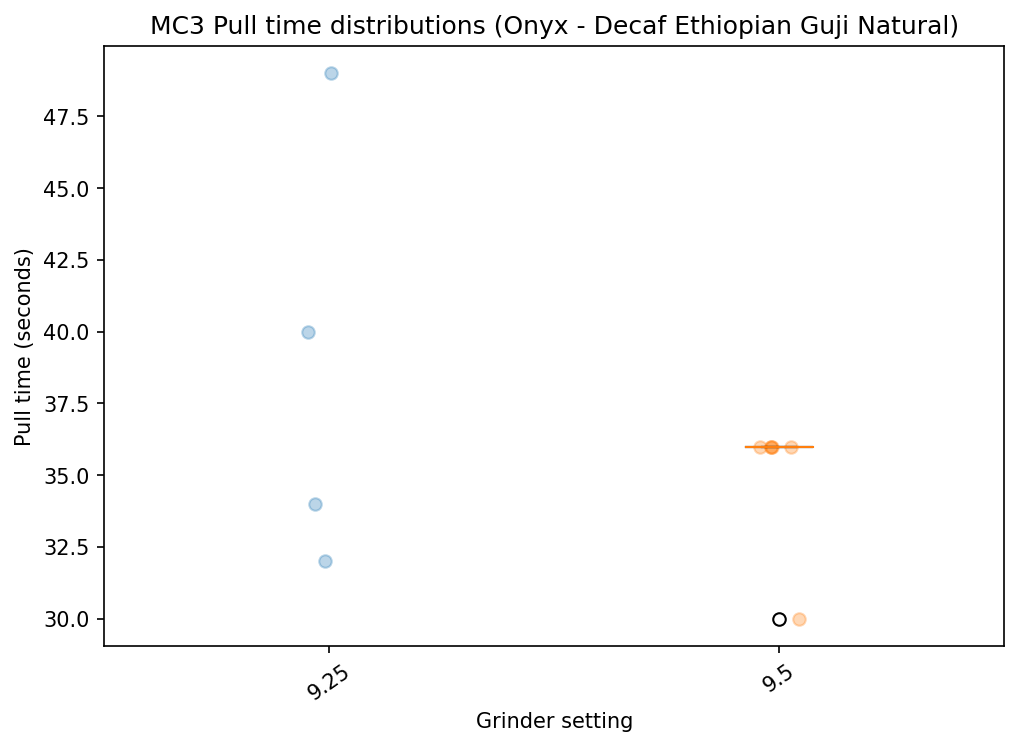

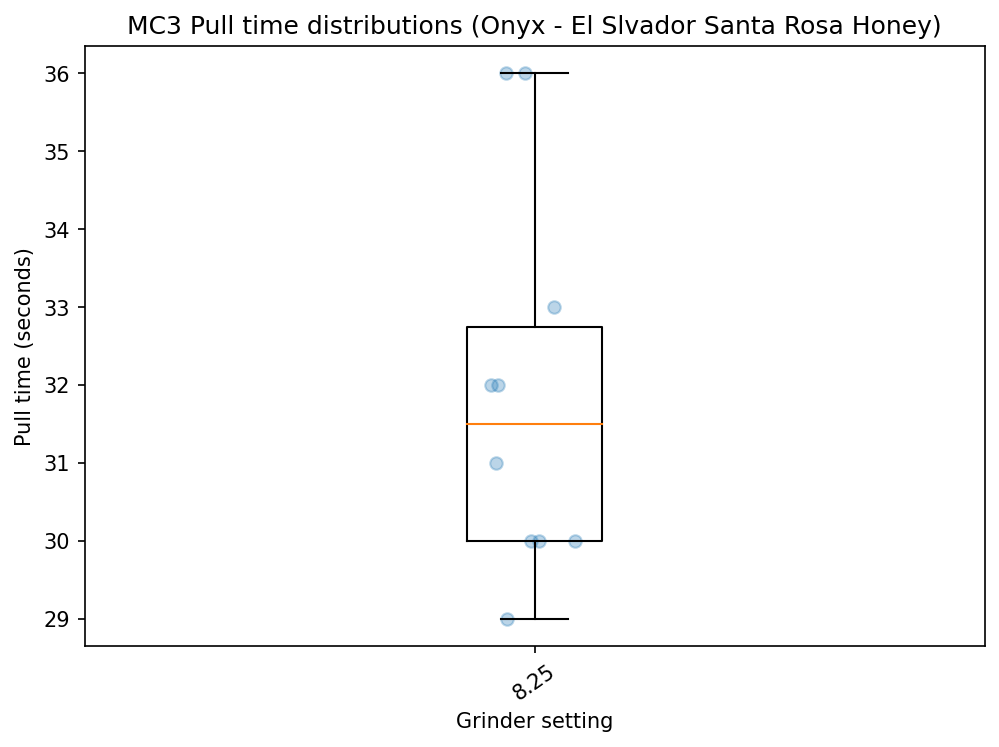

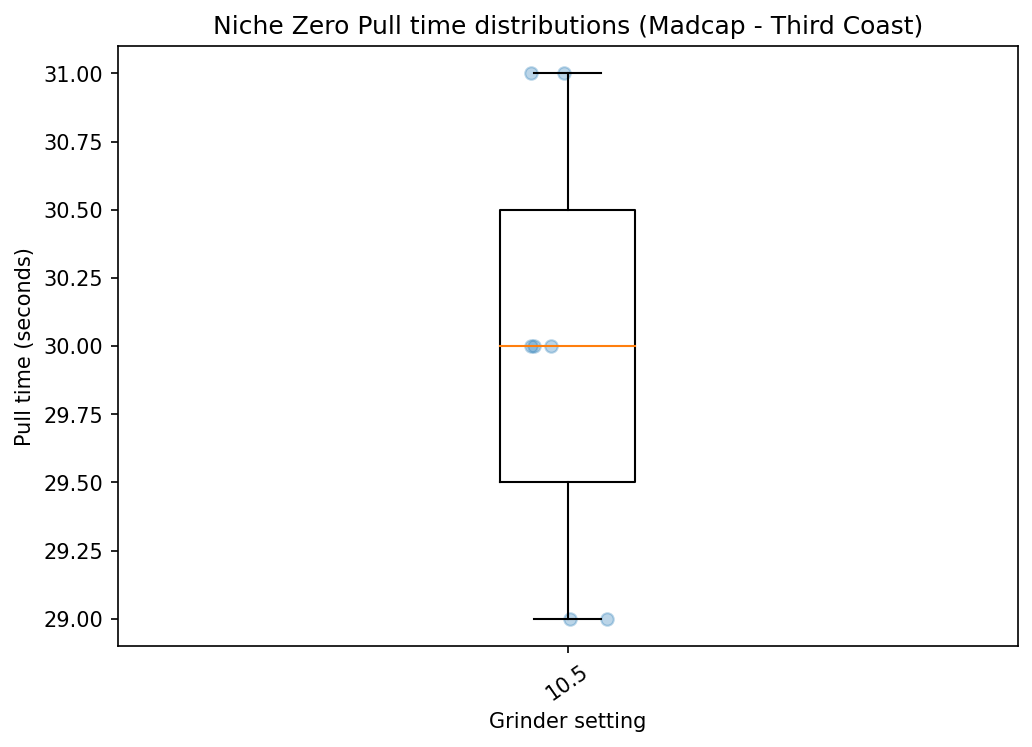

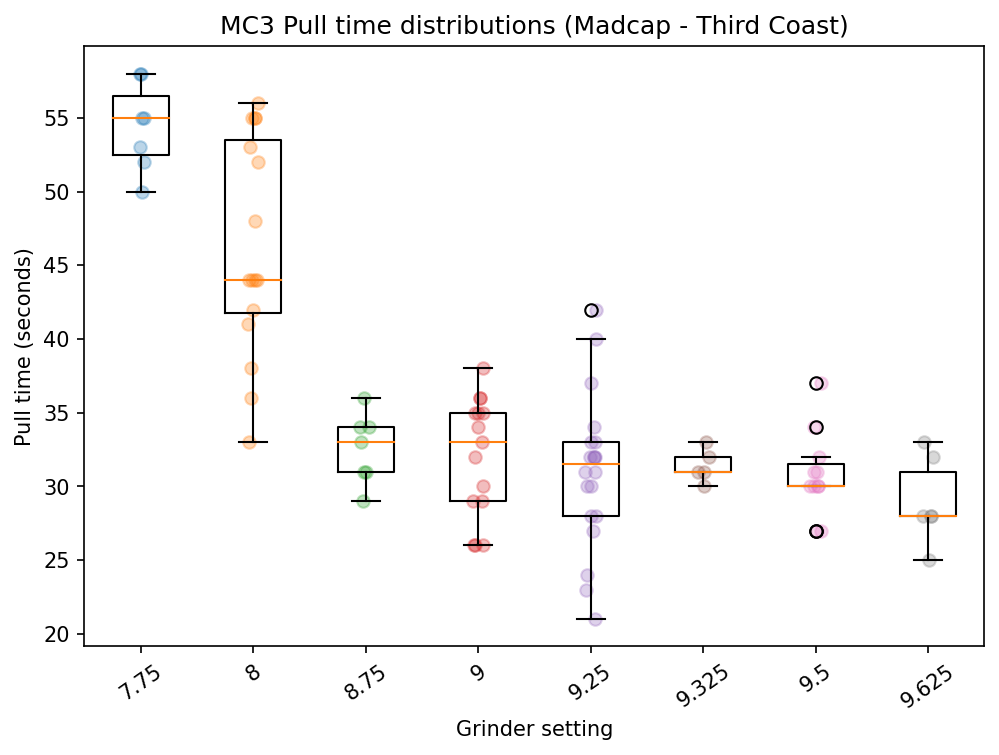

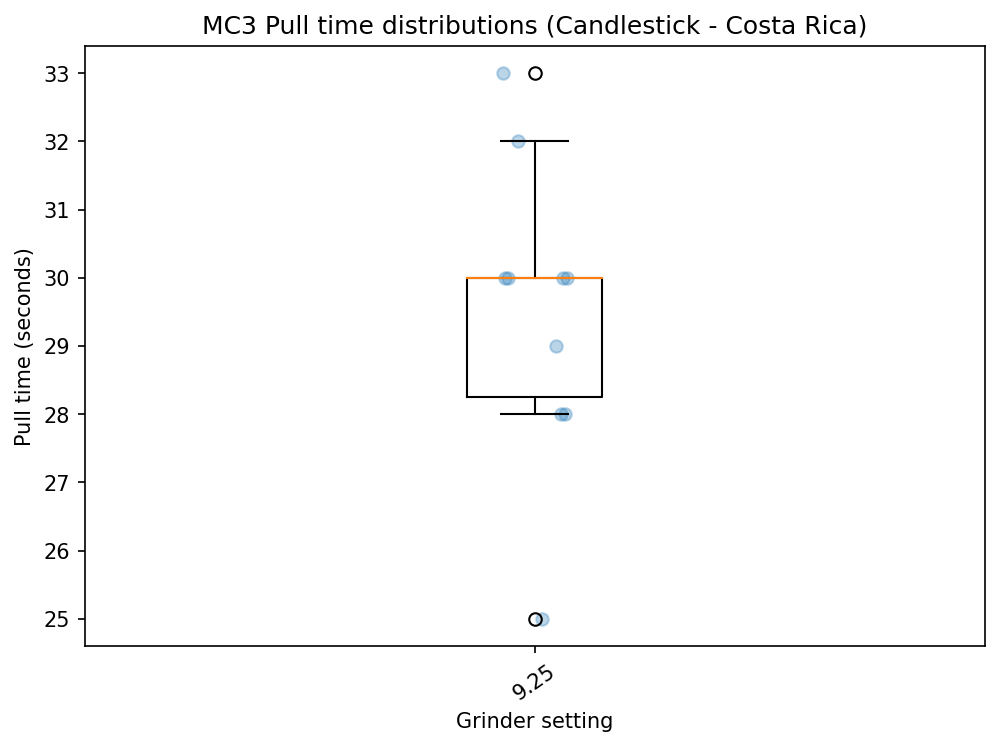

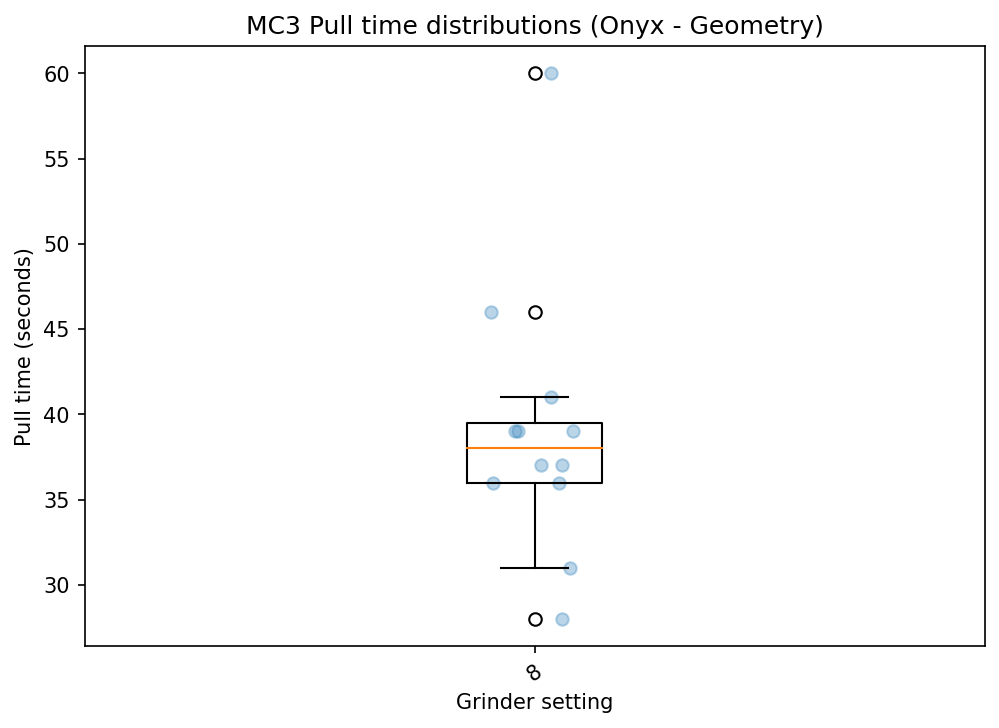

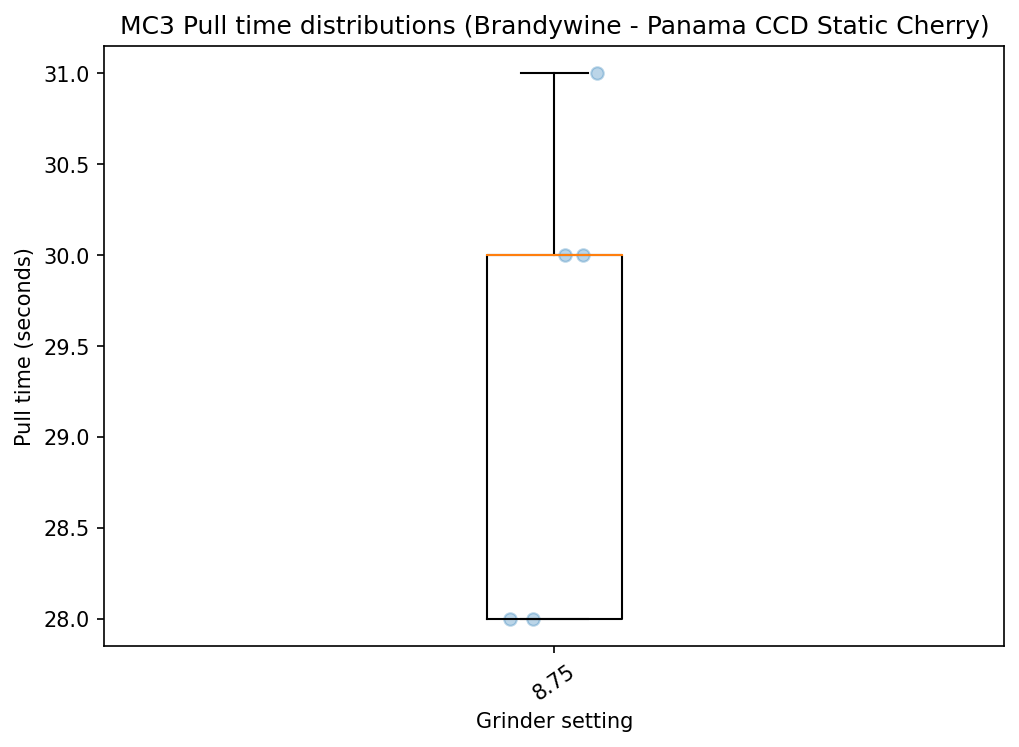

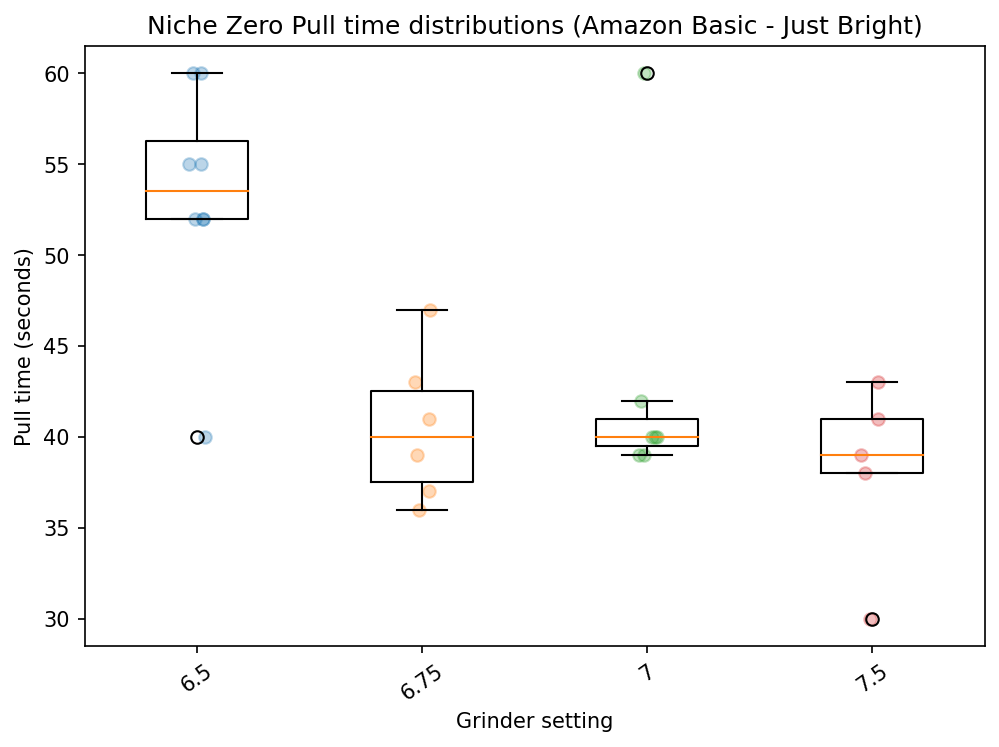

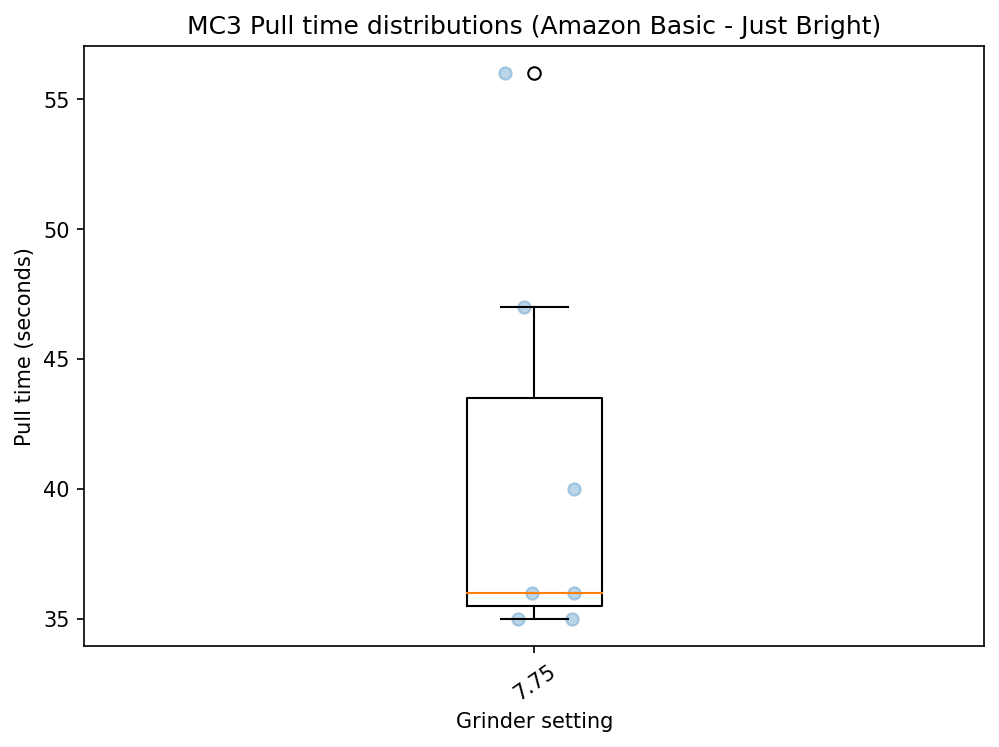

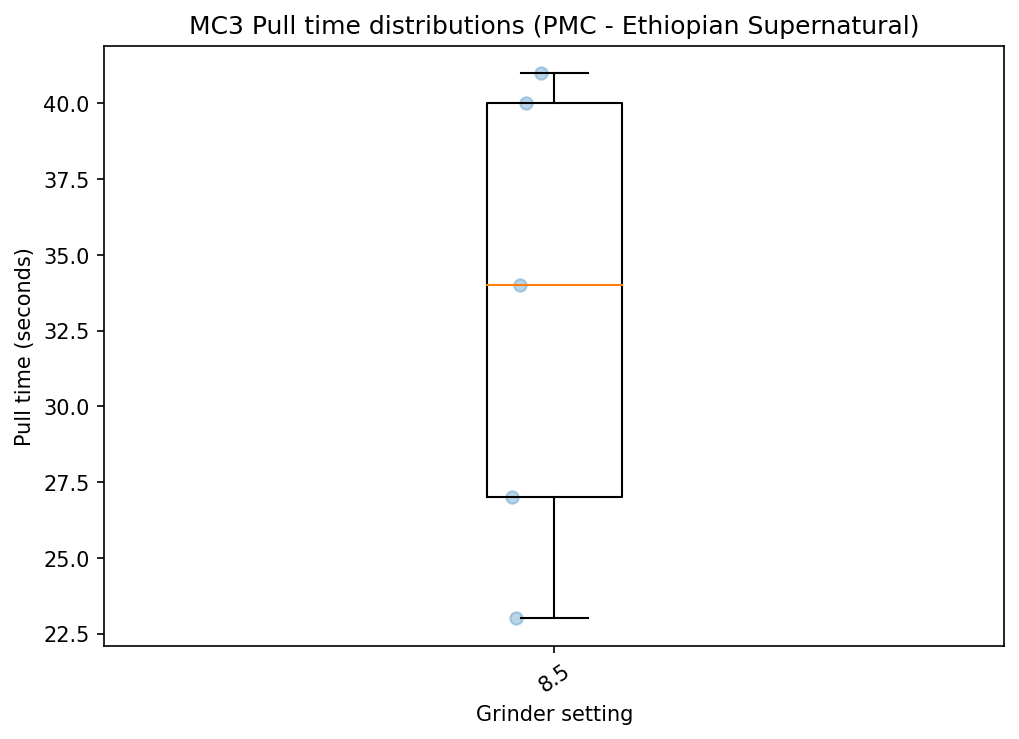

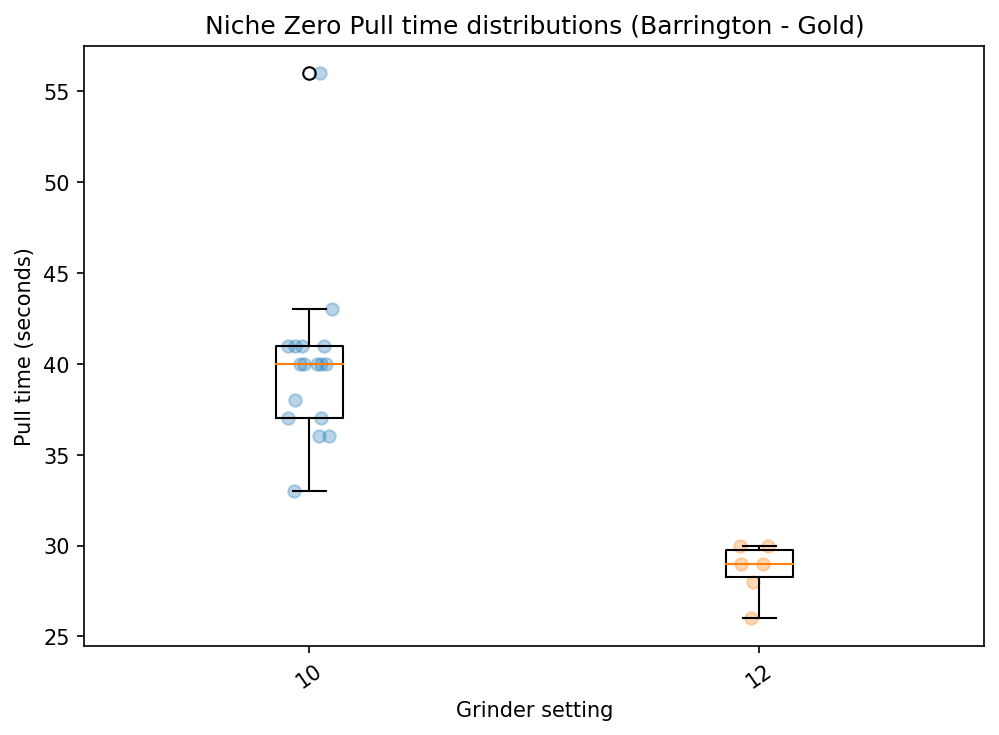

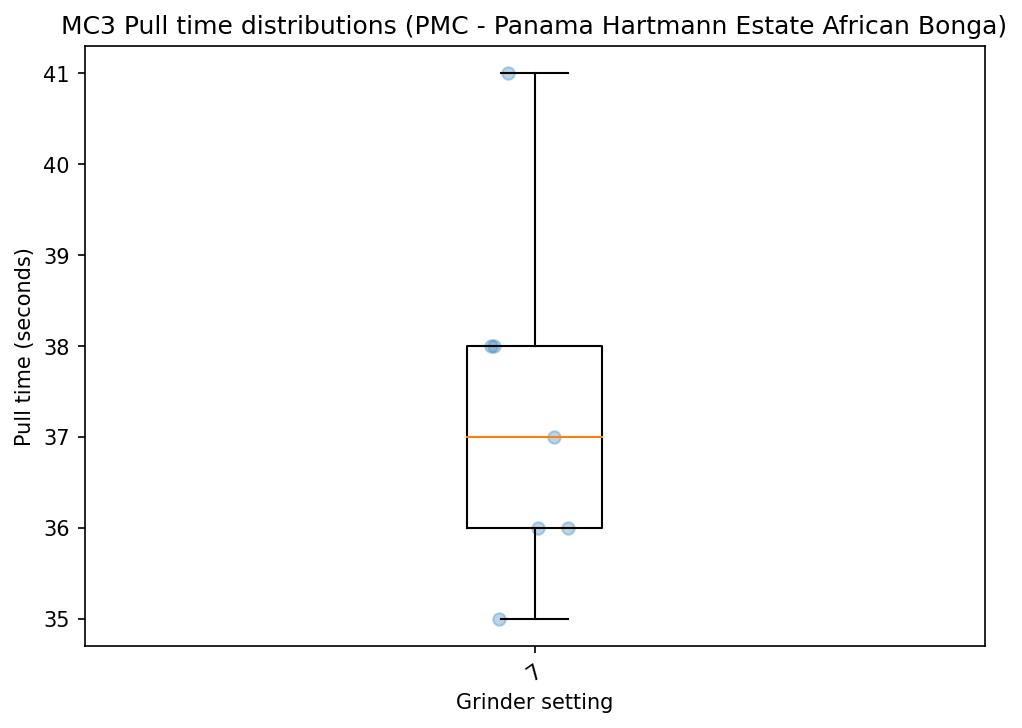

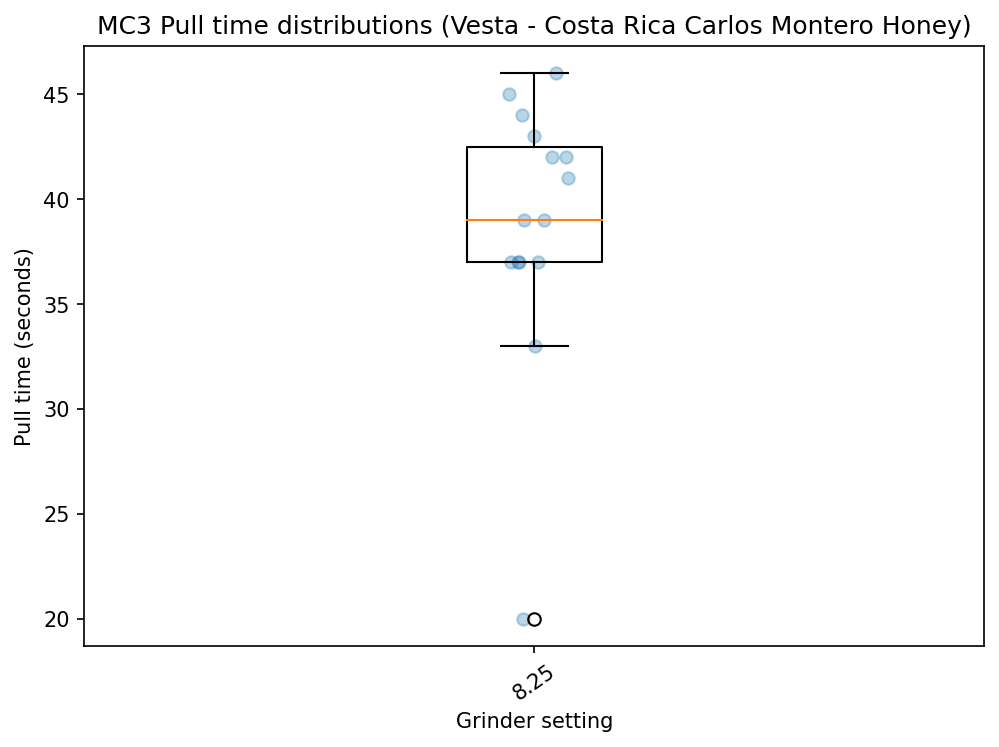

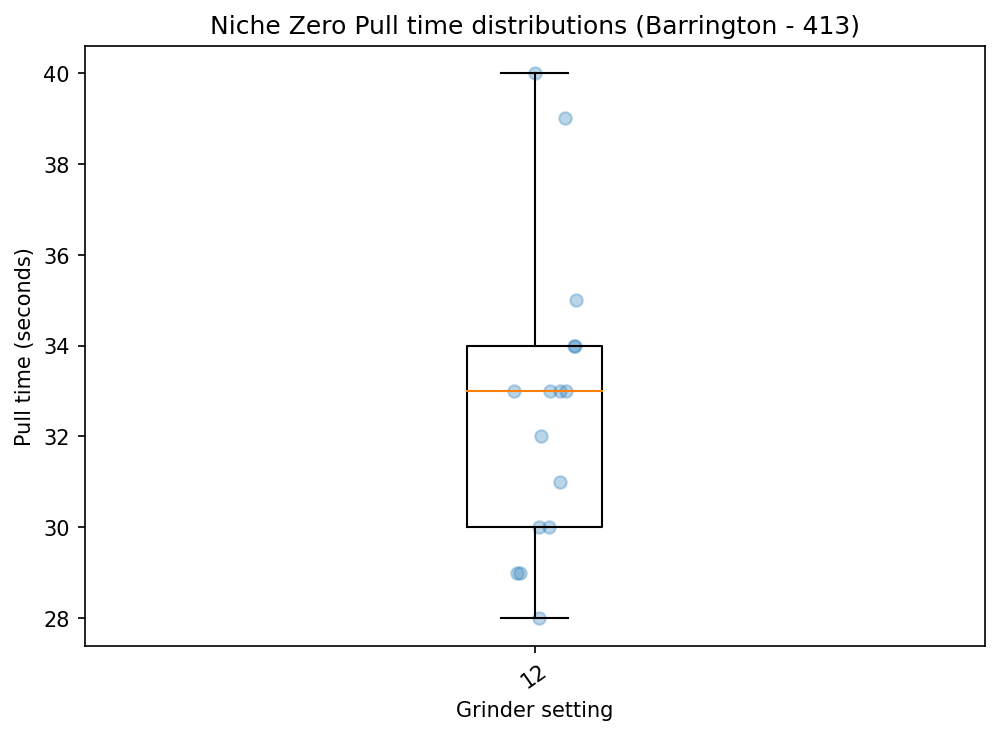

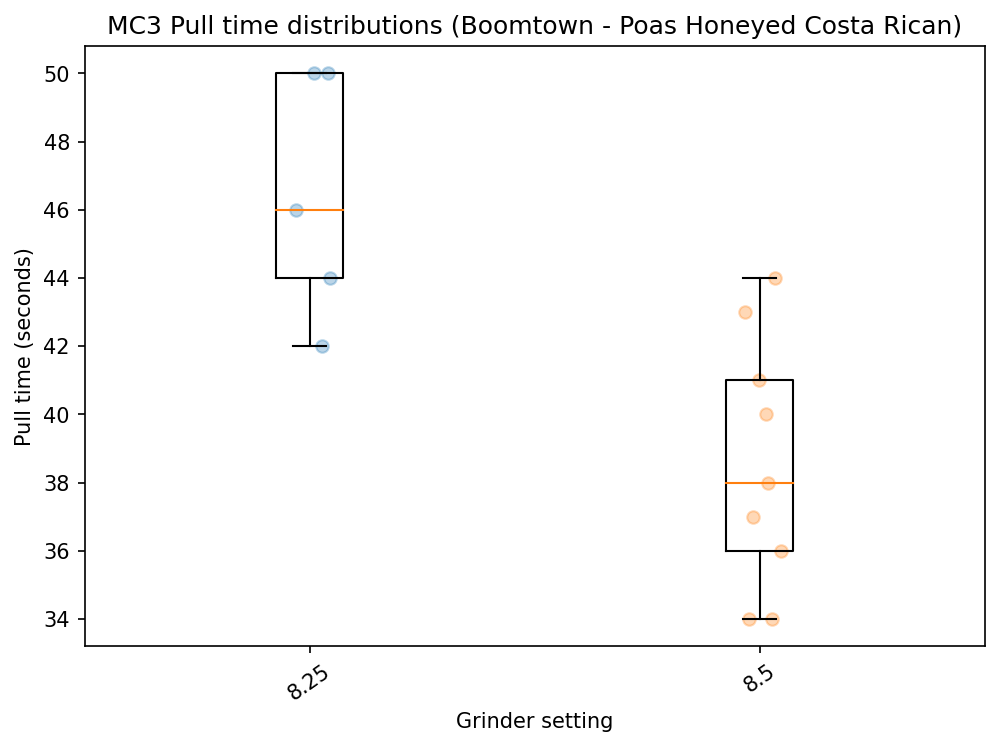

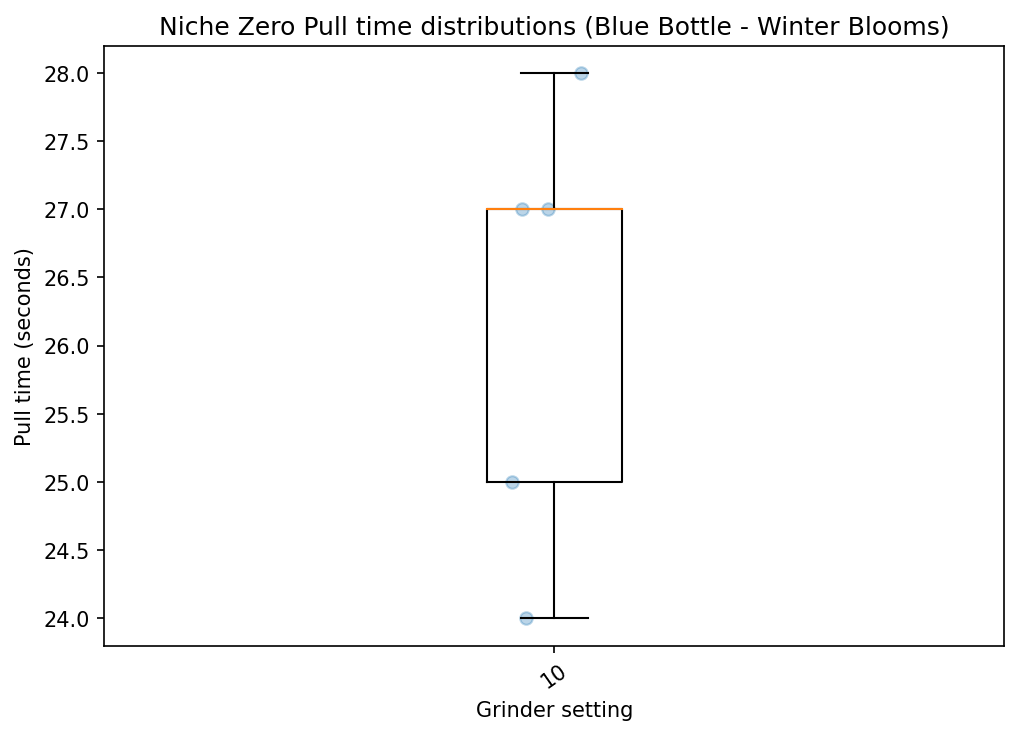

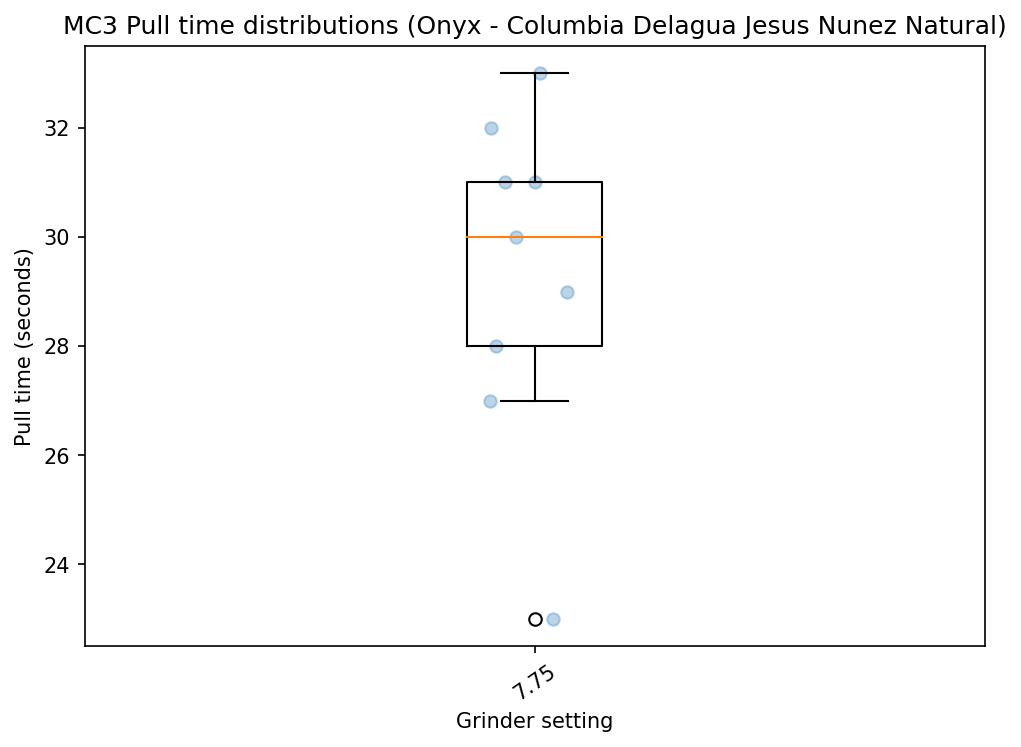

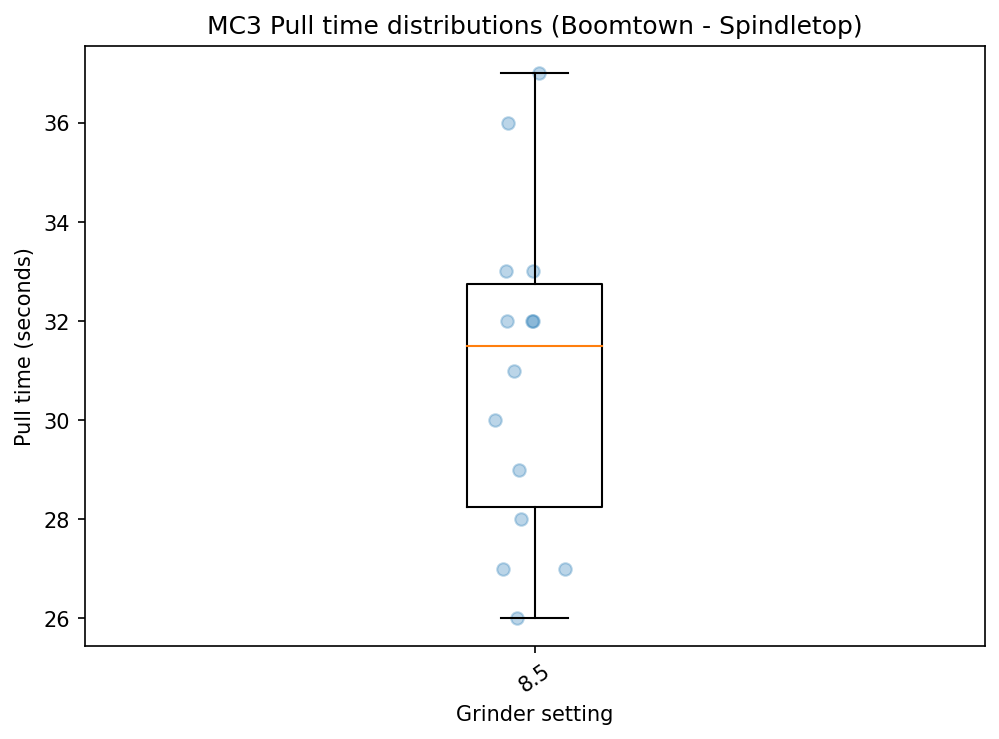

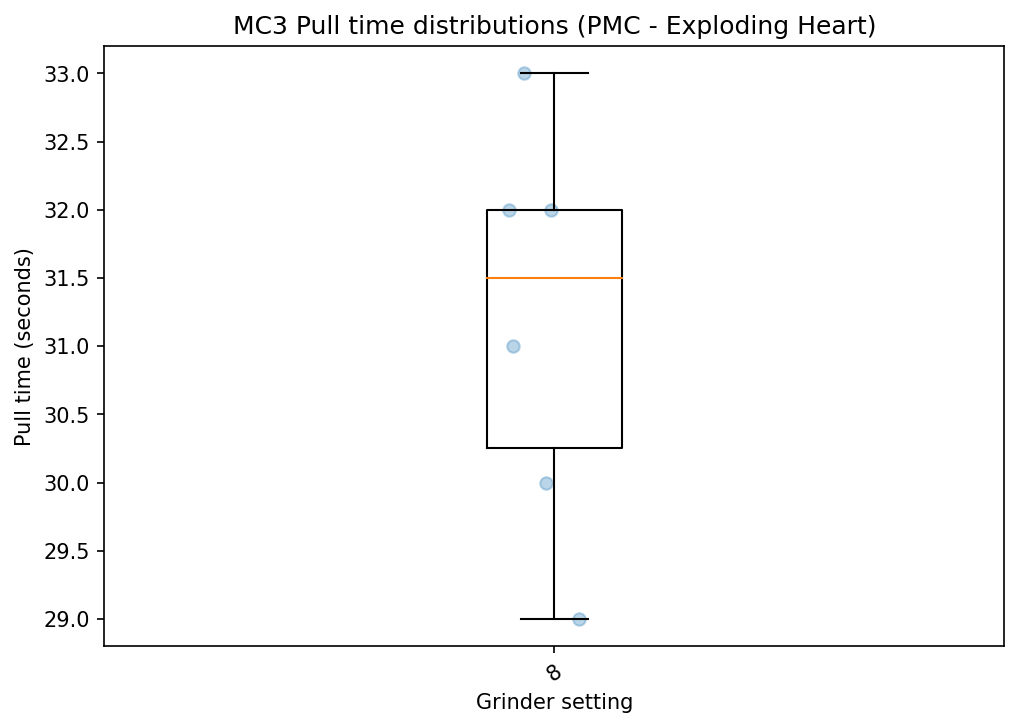

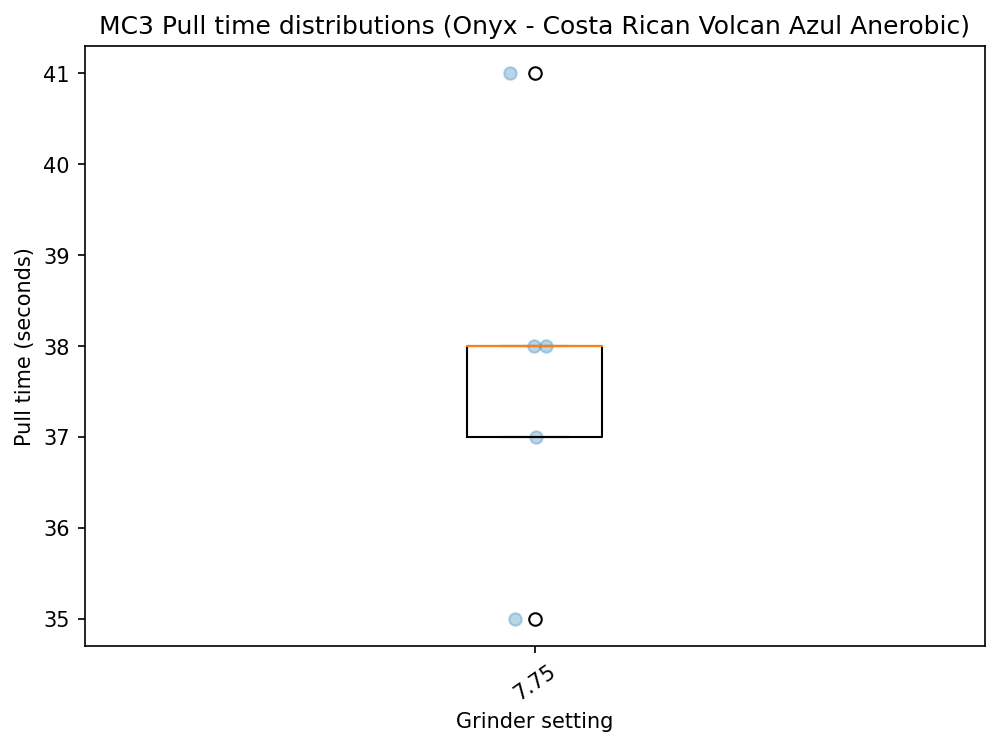

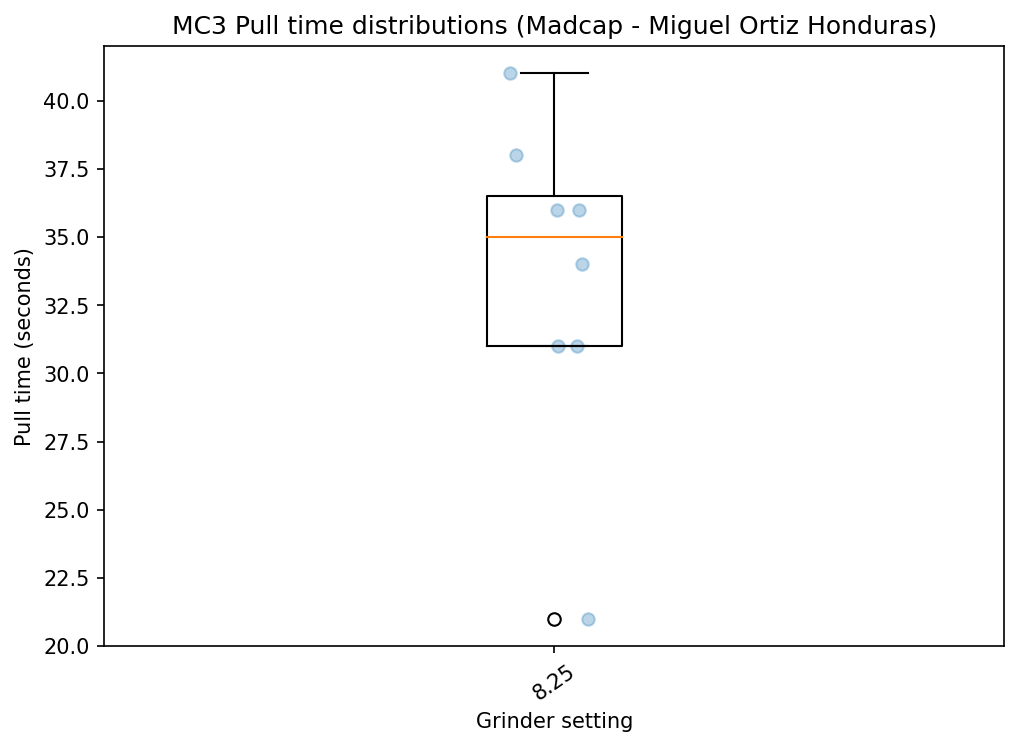

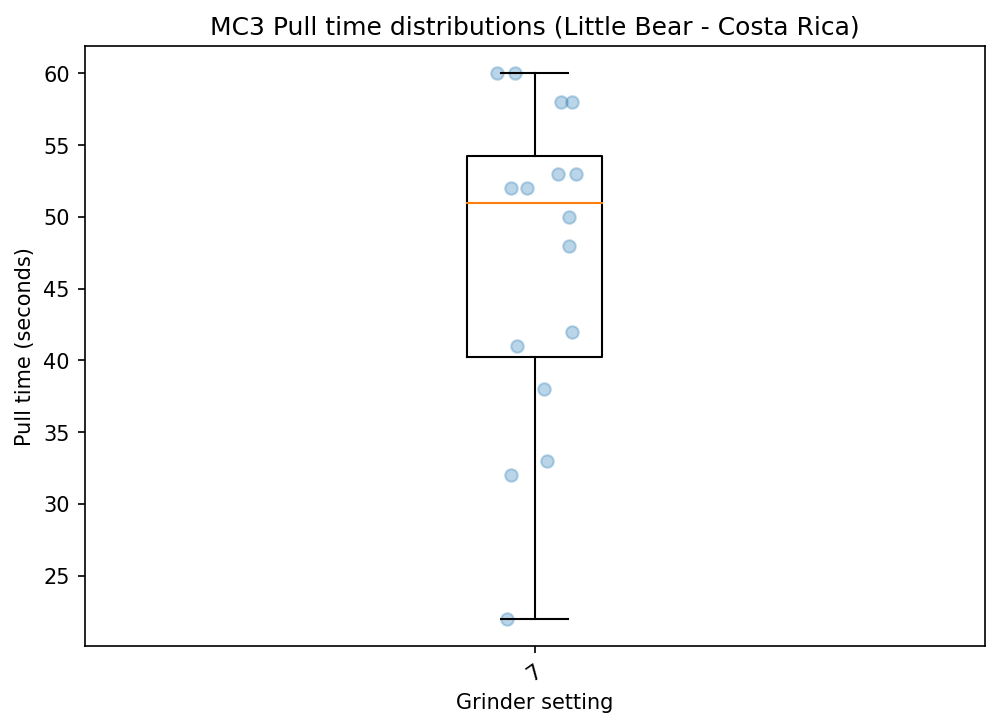

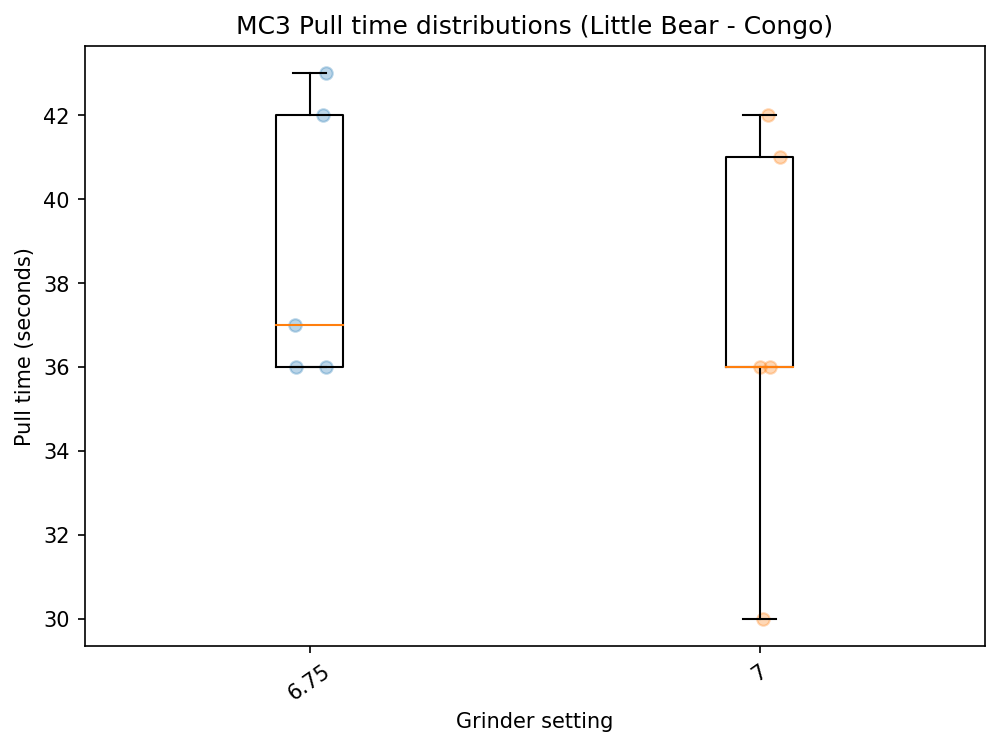

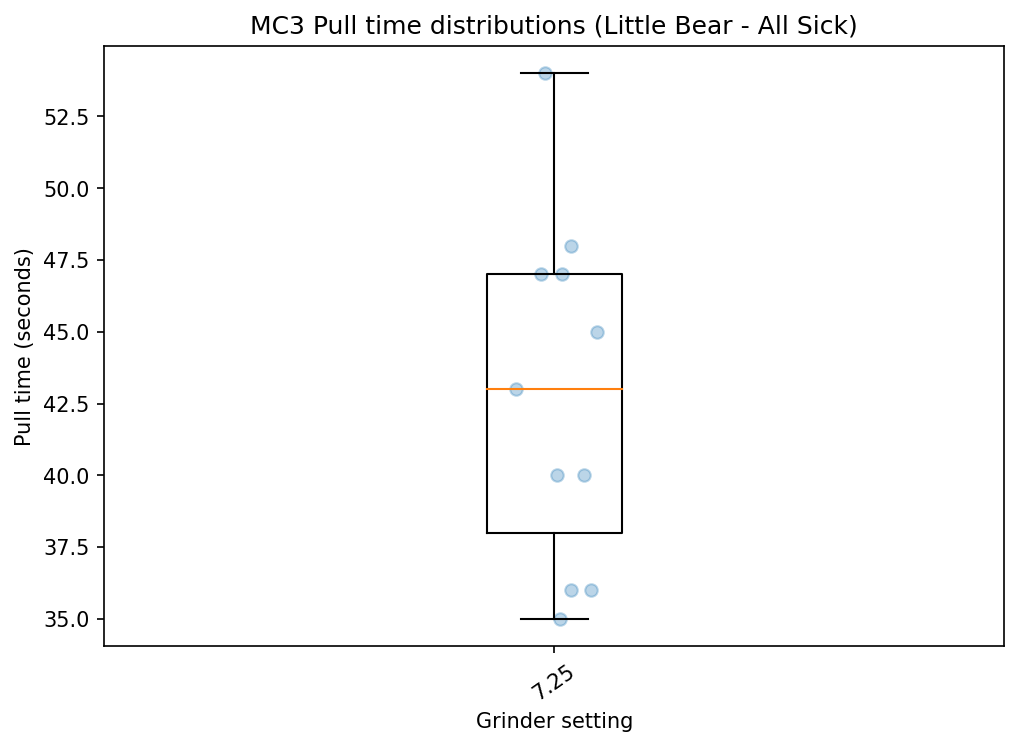

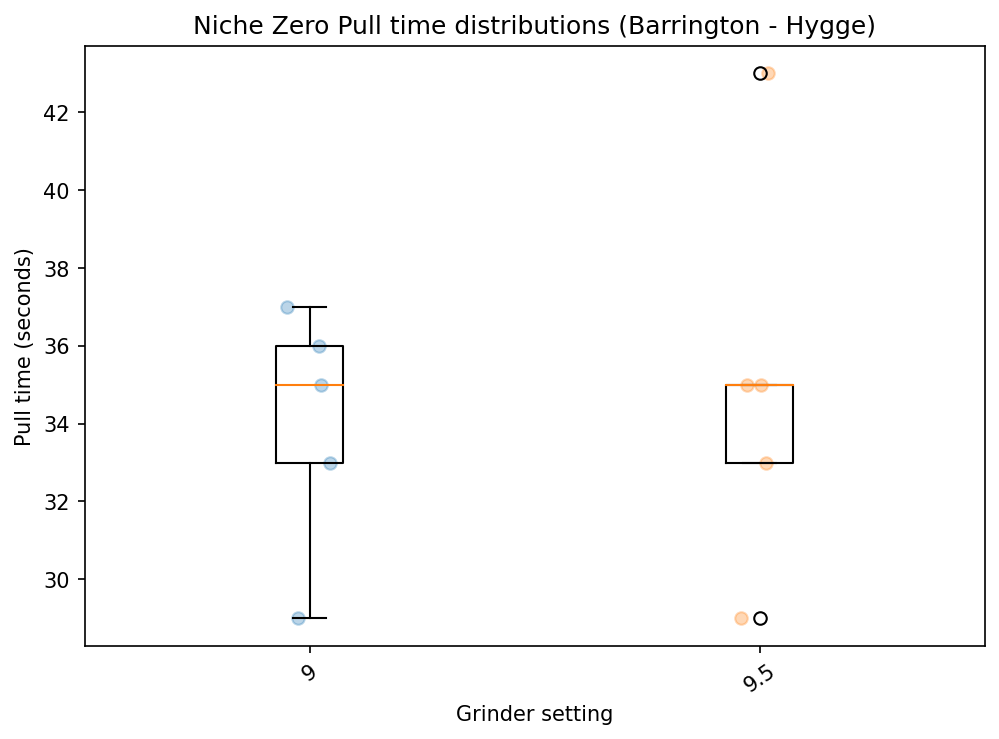

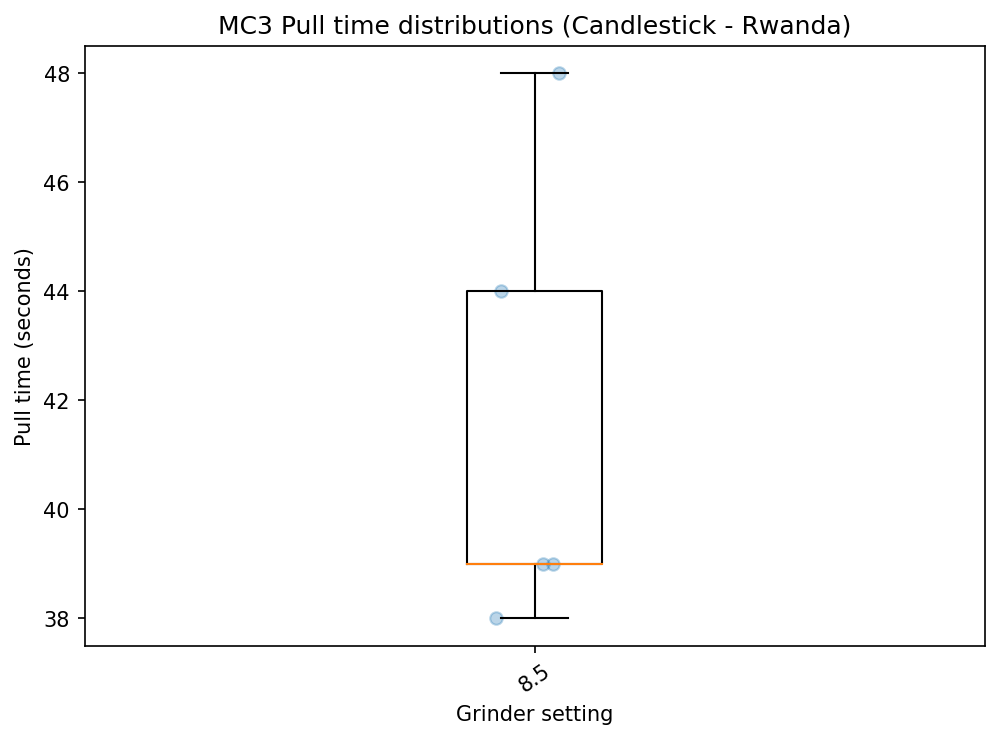

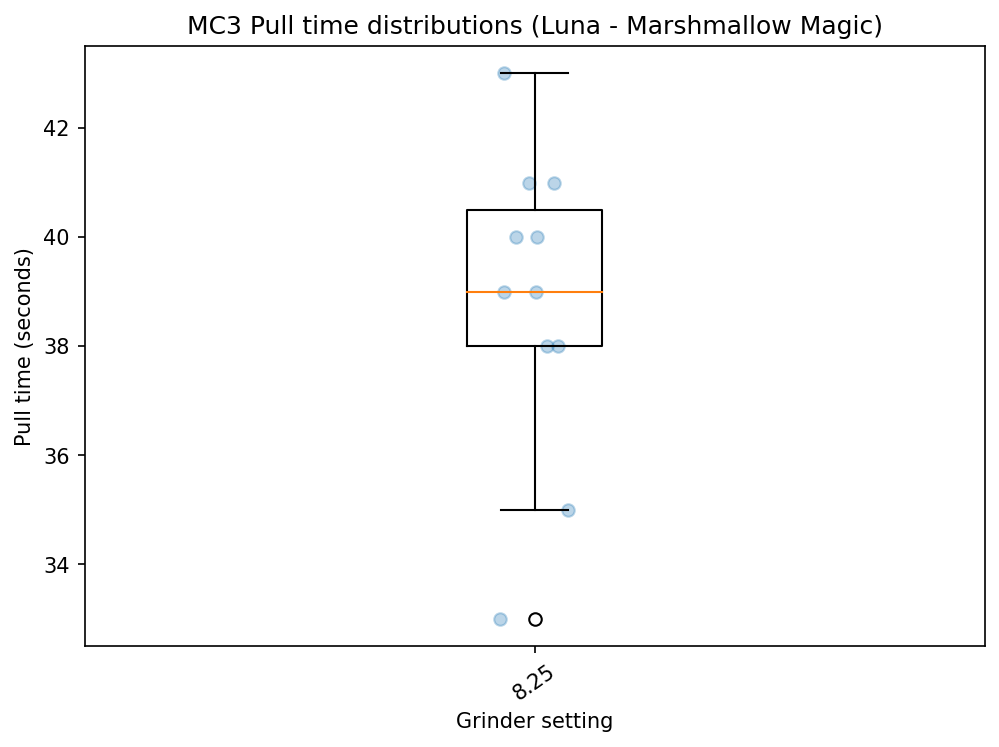

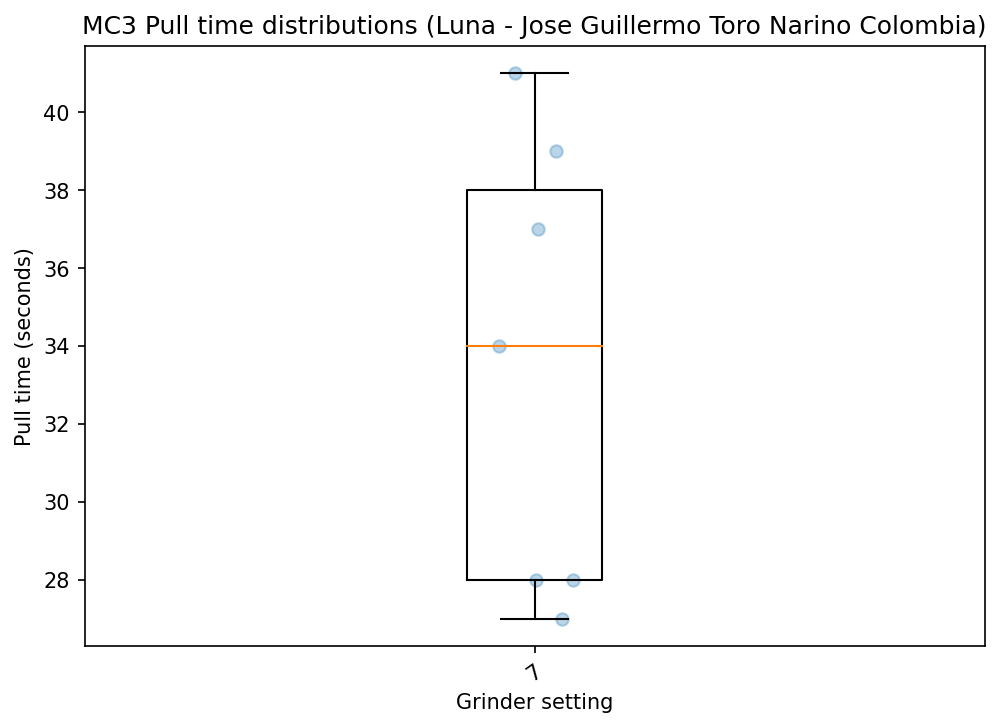

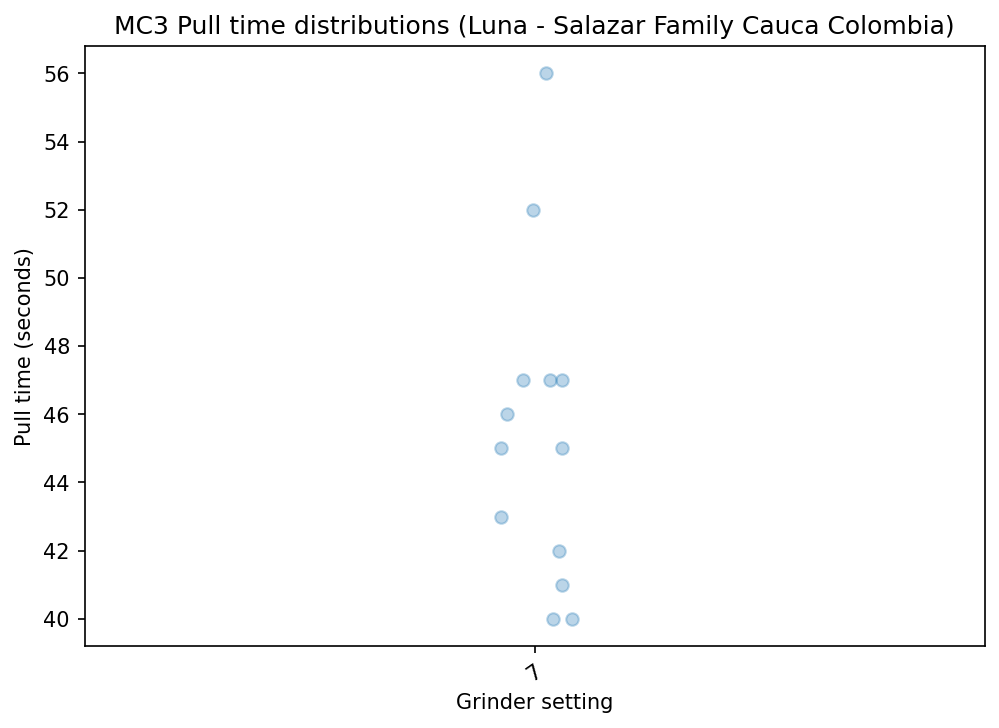

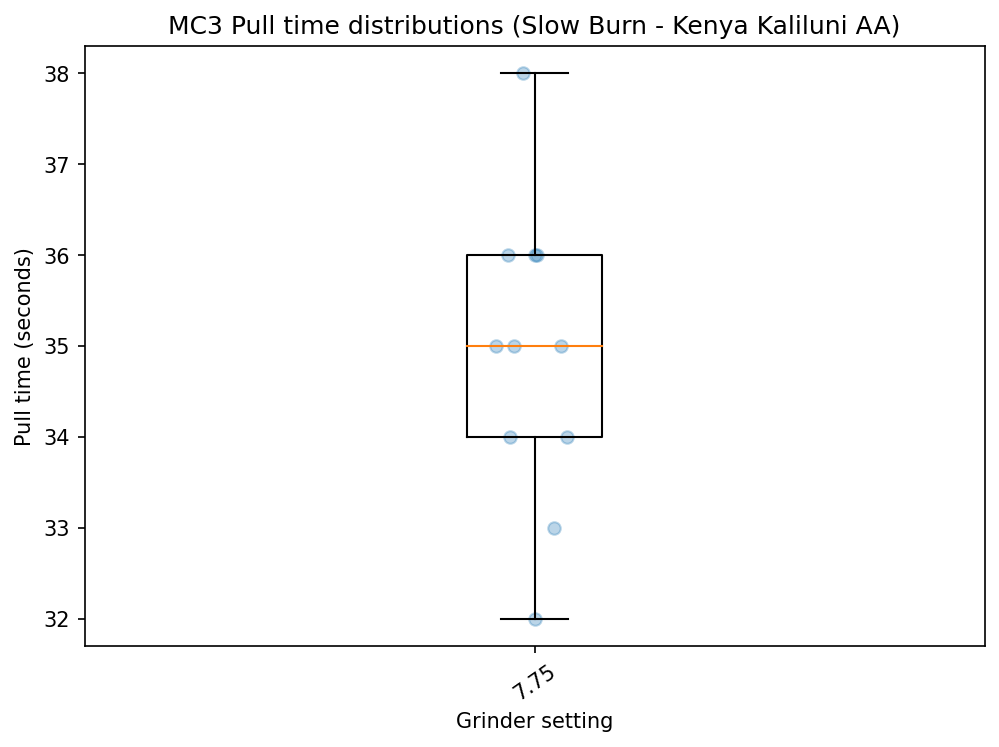

In [6]:
grinders = df.grinder.unique()
def sort_key(x):
    try:
        return float(x)
    except Exception:
        pass
    try:
        return int(x)
    except Exception:
        pass
    return x

for coffee in df.coffee.unique():
    for grinder in grinders:
        columns = []
        times = []
        fig = plt.Figure()
        axe = fig.add_axes([0, 0, 1, 1])
        subdf = df[(df["grinder"] == grinder) & (df["coffee"] == coffee)]
        if subdf.empty:
            continue
        for grind in sorted(subdf.grindersetting.unique(), key=sort_key):
            grind_time = subdf[subdf["grindersetting"] == grind].time.tolist()
            if 20 < len(grind_time) or len(grind_time) < 5:
                continue
            columns.append(grind)
            times.append(grind_time)
        if len(columns) == 0:
            continue
        axe.boxplot(times, labels=columns)
        i = 0
        uni_range = 0.05
        for column, vals in zip(columns, times):
            center = i+1
            axe.scatter(np.random.uniform(center - uni_range, center + uni_range, len(vals)), vals, alpha=0.3)
            i += 1
        axe.set_xticklabels(columns, rotation=35, ha='center')
        fig.suptitle('')
        axe.set_title(f"{grinder} Pull time distributions ({coffee})")
        axe.set_ylabel("Pull time (seconds)")
        axe.set_xlabel("Grinder setting")
        display(fig)